In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [3]:
# Grid and environment setup
GRID_SIZE = 100
OBSTACLE_RATIO = 0.2  # 20% of the grid as obstacles
START, GOAL = (0, 0), (GRID_SIZE-1, GRID_SIZE-1)


In [4]:
# Create grid and add obstacles
def create_grid():
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    obstacles = np.random.choice([0, 1], size=(GRID_SIZE, GRID_SIZE), p=[1 - OBSTACLE_RATIO, OBSTACLE_RATIO])
    grid = np.where(obstacles == 1, -1, 0)  # -1 represents an obstacle
    grid[START] = 0  # Ensure start is not blocked
    grid[GOAL] = 0   # Ensure goal is not blocked
    return grid

grid = create_grid()

# MDP and Reward Setup
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
REWARD_STEP = -1
REWARD_GOAL = 100
REWARD_OBSTACLE = -100

In [5]:
# Check if the position is valid
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and grid[x, y] != -1


In [6]:
# Transition function
def transition(state, action):
    next_state = (state[0] + action[0], state[1] + action[1])
    if is_valid(next_state):
        return next_state
    return state  # remain in place if the move is invalid

In [7]:

# Visualize the grid
def plot_grid(grid, path=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray_r')
    plt.scatter(*START[::-1], c='blue', s=100, label="Start")
    plt.scatter(*GOAL[::-1], c='green', s=100, label="Goal")
    if path:
        for (x, y) in path:
            plt.scatter(y, x, c='red', s=10)
    plt.legend()
    plt.show()

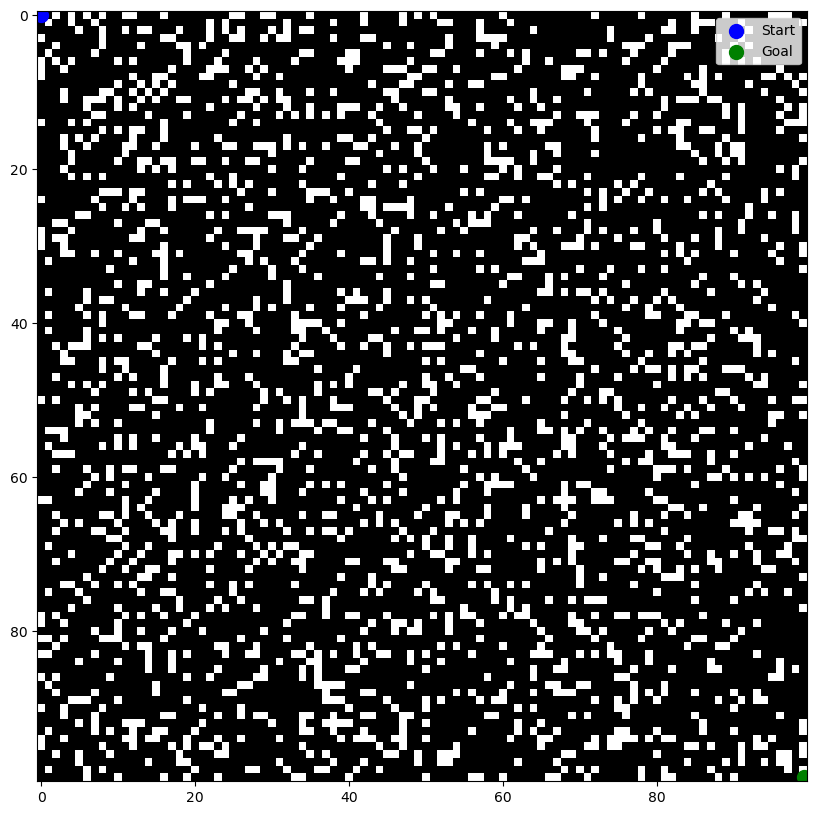

In [8]:
# Display the initial grid setup
plot_grid(grid)

In [9]:
### Dynamic Programming - Value Iteration
def value_iteration(grid, gamma=0.9, threshold=1e-4):
    values = np.zeros_like(grid, dtype=float)
    policy = np.zeros(grid.shape + (len(ACTIONS),))  # Policy table
    while True:
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if (x, y) == GOAL:
                    continue
                v = values[x, y]
                action_values = []
                for a, action in enumerate(ACTIONS):
                    next_state = transition((x, y), action)
                    reward = REWARD_GOAL if next_state == GOAL else REWARD_STEP
                    action_values.append(reward + gamma * values[next_state])
                values[x, y] = max(action_values)
                policy[x, y] = np.eye(len(ACTIONS))[np.argmax(action_values)]
                delta = max(delta, abs(v - values[x, y]))
        if delta < threshold:
            break
    return values, policy

values_dp, policy_dp = value_iteration(grid)

In [10]:
### Q-Learning Implementation
def q_learning(grid, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = defaultdict(lambda: np.zeros(len(ACTIONS)))
    for episode in range(episodes):
        state = START
        while state != GOAL:
            if random.random() < epsilon:
                action_index = random.randint(0, len(ACTIONS) - 1)
            else:
                action_index = np.argmax(q_values[state])
            action = ACTIONS[action_index]
            next_state = transition(state, action)
            reward = REWARD_GOAL if next_state == GOAL else REWARD_STEP if grid[next_state] == 0 else REWARD_OBSTACLE
            best_next_action = np.argmax(q_values[next_state])
            td_target = reward + gamma * q_values[next_state][best_next_action]
            q_values[state][action_index] += alpha * (td_target - q_values[state][action_index])
            state = next_state
    return q_values

q_values_qlearning = q_learning(grid)

In [11]:
### SARSA Implementation
def sarsa(grid, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = defaultdict(lambda: np.zeros(len(ACTIONS)))
    for episode in range(episodes):
        state = START
        if random.random() < epsilon:
            action_index = random.randint(0, len(ACTIONS) - 1)
        else:
            action_index = np.argmax(q_values[state])
        while state != GOAL:
            action = ACTIONS[action_index]
            next_state = transition(state, action)
            reward = REWARD_GOAL if next_state == GOAL else REWARD_STEP if grid[next_state] == 0 else REWARD_OBSTACLE
            if random.random() < epsilon:
                next_action_index = random.randint(0, len(ACTIONS) - 1)
            else:
                next_action_index = np.argmax(q_values[next_state])
            td_target = reward + gamma * q_values[next_state][next_action_index]
            q_values[state][action_index] += alpha * (td_target - q_values[state][action_index])
            state, action_index = next_state, next_action_index
    return q_values

q_values_sarsa = sarsa(grid)

In [13]:
### Benchmarking and Results
def get_policy_from_q(q_values):
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            policy[x, y] = np.argmax(q_values[(x, y)])
    return policy

policy_qlearning = get_policy_from_q(q_values_qlearning)
policy_sarsa = get_policy_from_q(q_values_sarsa)

In [14]:
print("DP Policy Example:")
print(policy_dp[:10, :10])

DP Policy Example:
[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 

In [15]:
print("\nQ-Learning Policy Example:")
print(policy_qlearning[:10, :10])


Q-Learning Policy Example:
[[1 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 0 2 0 0 1 1]
 [3 3 1 3 1 0 2 1 0 2]
 [0 3 1 3 2 0 2 1 0 2]
 [2 3 0 2 3 3 1 3 0 1]
 [3 0 1 1 3 1 3 0 0 3]
 [0 0 0 2 0 2 0 2 0 3]
 [0 1 0 0 1 3 3 3 0 1]
 [0 2 0 1 1 3 2 3 1 0]
 [0 1 2 0 3 2 1 3 2 3]]


In [16]:
print("\nSARSA Policy Example:")
print(policy_sarsa[:10, :10])


SARSA Policy Example:
[[3 0 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 1 2 0 2 0]
 [3 1 0 2 2 0 2 0 0 3]
 [0 1 3 1 3 1 0 0 0 3]
 [1 2 0 3 3 3 2 0 0 2]
 [0 0 1 1 3 1 0 0 3 3]
 [0 0 0 2 0 3 3 3 0 1]
 [0 0 0 0 0 1 0 0 0 3]
 [0 2 2 1 2 0 2 2 1 0]
 [2 1 0 2 2 0 2 2 3 3]]


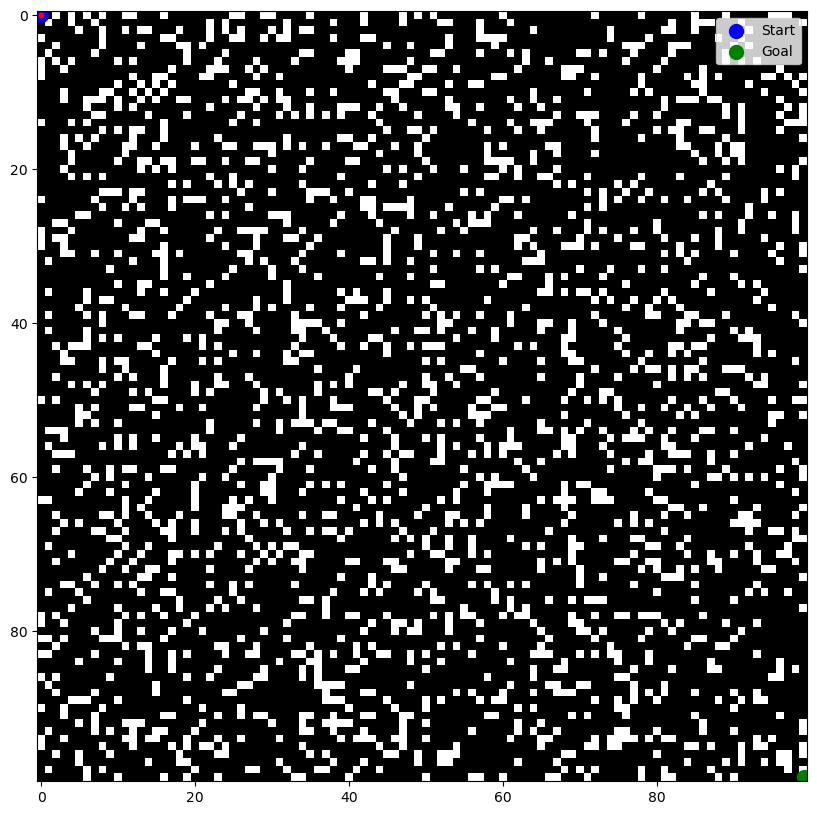

In [17]:
plot_grid(grid, path=[START])  # To visualize